<font color=blue><font size =6> Data Explanation </font></font><br>
이 데이터는 시계열 데이터 예측을 위한 Sample1(5)로 자세한 내용은 데이터 보안성에 의해 유출불가
-> 따라서 일부 결과에 output이 누락 돼있을 수 있다( 단 중요 output은 나와있음 )

이번에는 이전 project와의 차이점으로 prediction방식을 바꿔서 visualizing까지 해보겠다

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import DeepAR

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv('../data/5.csv')
data.rename(columns={'a':'group_ids'},inplace=True)
data['group_ids']=np.tile('0',len(data))
data

,group_ids,b,values,c,d
0,0,2018-07-25 00:00:00,92408,26971036,177711644
1,0,2018-07-25 00:01:00,92150,26948190,220370286
2,0,2018-07-25 00:02:00,94896,26238222,188035073
3,0,2018-07-25 00:03:00,92694,26087970,191997884
4,0,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521,23637112,138239574
38876,0,2018-08-20 23:56:00,83092,24617816,164460450
38877,0,2018-08-20 23:57:00,84873,25101336,173568370
38878,0,2018-08-20 23:58:00,81736,24181689,157334718


In [5]:
data.drop(columns=['c','d'],axis=1,inplace=True)

In [32]:
data.isnull().sum()

group_ids    0
b            0
values       0
dtype: int64

In [6]:
data['time_idx'] = np.tile(np.arange(len(data)),1) 
data['b'] = pd.to_datetime(data['b'])
data['values'] = pd.to_numeric(data['values'],downcast='float')
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,92408.0,0
1,0,2018-07-25 00:01:00,92150.0,1
2,0,2018-07-25 00:02:00,94896.0,2
3,0,2018-07-25 00:03:00,92694.0,3
4,0,2018-07-25 00:04:00,93674.0,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [26]:
data['b'].iloc[-1]-data['b'].iloc[0]

Timedelta('26 days 23:59:00')

* 누락 데이터 없음

<font size=6><font color = blue> Set TimeSeriesDataSet </font></font>

데이터는 총 38880개의 데이터를 갖고 있다 이를 train,test set으로 8:2의 비율로 나누고 train set에서 또 8:2의 비율로 validation set과 actual train set으로 나누겠다 따라서 다음의 데이터 개수를 갖게 된다

TestSet: 7776<br>
TrainSet: 24883<br>
ValidationSet: 6221

In [34]:
Training_cutoff = 24883
Train_df = data.iloc[:Training_cutoff+6221]
Test_df = data.iloc[Training_cutoff+6221:]

In [35]:
max_encoder_length = 60
max_prediction_length = 20
min_encoder_length = max_encoder_length
min_prediction_length = max_prediction_length

In [36]:
Train_tsd = TimeSeriesDataSet(
    data = Train_df.iloc[:Training_cutoff+1],
    time_idx = "time_idx",
    target = "values",
    group_ids = ["group_ids"],
    max_encoder_length = max_encoder_length,
    min_encoder_length = min_encoder_length,
    max_prediction_length = max_prediction_length,
    min_prediction_length = min_prediction_length,
    time_varying_unknown_reals = ["values"]
)
Train_tsd

TimeSeriesDataSet[length=24805](
	time_idx='time_idx',
	target='values',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['values'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [28]:
Validation = data.iloc[Training_cutoff+1:Training_cutoff+6221]
Validation

,group_ids,datetime,volumn,time_idx
24884,0,2018-08-11 06:44:00,112668.0,24884
24885,0,2018-08-11 06:45:00,115721.0,24885
24886,0,2018-08-11 06:46:00,117100.0,24886
24887,0,2018-08-11 06:47:00,118102.0,24887
24888,0,2018-08-11 06:48:00,115409.0,24888
...,...,...,...,...
31099,0,2018-08-15 14:19:00,361458.0,31099
31100,0,2018-08-15 14:20:00,360029.0,31100
31101,0,2018-08-15 14:21:00,361359.0,31101
31102,0,2018-08-15 14:22:00,366484.0,31102


In [29]:
batch_size = 64
Train_loader = Train_tsd.to_dataloader(train = True,
                                       batch_size = batch_size,
                                       #batch_sampler = "synchronized",
                                       num_workers = 0)

<font size=6><font color = blue> Set Trainer </font></font>

In [23]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping

In [32]:
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")

In [20]:
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val = 0.1, #gradient_clip_val: The value at which to clip gradients
    max_epochs = 50,
    callbacks = [lr_find,early_stopping]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<font size=6><font color = blue> Set Seed for reproduceable results</font></font>

In [21]:
pl.seed_everything(42)

Global seed set to 42


42

<font size=6><font color = blue> Set Model </font></font>

In [23]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16, 
                        # Q. hidden_vector의 크기가 모델의 성능에 영향을 주나?
                        #hidden_size (int, optional) – hidden recurrent size - the most important hyperparameter along with rnn_layers. Defaults to 10.
                         optimizer = 'adam')
net

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       16
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              NormalDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"monotone_constaints":               {}
  	"n_plotting_samples":                None
  	"n_validation_samples":              None
  	"optimizer":                         adam
  	"optimizer_params":                  None
  	"output_transformer":       

In [ ]:
model = trainer.fit(net,
                    train_dataloaders = Train_loader,
                   )

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
"""
After training finishes, use best_model_path to retrieve the path 
to the best checkpoint file and best_model_score to retrieve its score.
"""
best_model_path

In [43]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [63]:
predictions,x = best_model.predict(Validation,mode="prediction",return_x=True)

In [64]:
predictions

tensor([[367154.7188, 366499.9062, 366969.3750, 367513.3750, 368276.8438,
         368680.5312, 368020.9688, 368719.2500, 368755.3750, 368961.4062,
         369098.4062, 368833.6875, 368945.5938, 369182.9688, 369699.1250,
         369536.1875, 369500.4062, 369593.8125, 370039.5312, 369907.5938]])

In [51]:
x

{'encoder_cat': tensor([], size=(1, 60, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[ 1.1249],
          [ 1.6210],
          [ 2.2254],
          [ 1.9931],
          [ 1.4028],
          [ 1.0707],
          [ 1.3464],
          [ 0.5816],
          [ 1.4746],
          [ 1.8037],
          [ 1.6419],
          [ 1.2712],
          [ 0.8790],
          [ 1.3188],
          [ 0.4597],
          [ 0.3974],
          [ 1.0781],
          [ 0.4444],
          [ 0.0598],
          [-1.2207],
          [-0.6513],
          [ 0.7944],
          [-0.6693],
          [-1.3802],
          [ 0.2519],
          [-0.0350],
          [-0.9111],
          [-1.0865],
          [-1.2153],
          [ 0.1713],
          [-0.1853],
          [ 0.5525],
          [ 0.4657],
          [-0.4321],
          [-1.2018],
          [-0.3455],
          [-0.5251],
          [-1.4950],
          [-0.8086],
          [-1.3933],
          [-0.3503],
          [-0.4554],
          [-0.2171],
          [-0.360

In [62]:
Validation.iloc[-79]

group_ids                      0
datetime     2018-08-15 13:05:00
volumn                  378735.0
time_idx                   31025
Name: 31025, dtype: object

~~Validation의 -80번째 행부터 -21번째 행까지 사용해서 -20번째부터 -1번째까지 예측을 한것을 볼 수 있다 내가 원하는 것은 validation 전체를 예측하는 것인데 이를 해결하기 위해선 prediction_length가 validation을 덮도록 조정해야한다~~

<font color = blue><br>
~~ prediction_length가 너무 길게 조정되면 예측 오류가 쌓이므로 마지막에는 안좋은 예측결과가 나올것이다 따라서 train_set 크기 자체를 늘리고 validation_set 크기를 줄이는 방향으로 코딩해보자 </font>
-> validation set의 크기 자체는 작아도 괜찮을 것 같다
~~

<font color = blue> <font size = 5> 좀더 깊이 생각해 봤을때 </font></font>

--------------------------val_dataloader를 사용했을때--------------------------------
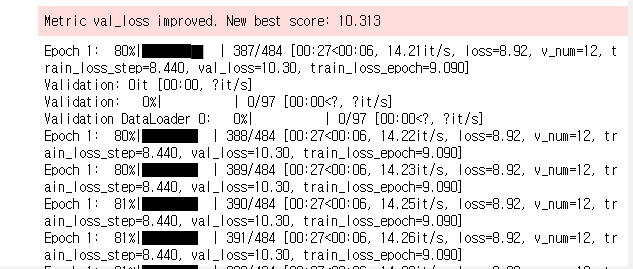
--------------------------val_dataloader를 사용안했을때------------------------------
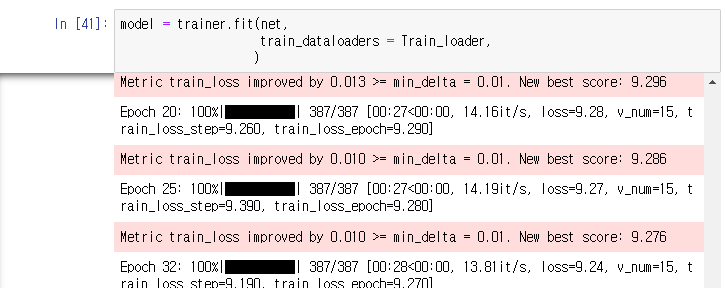 

Val_dataloader를 사용했을때는 Val_dataloader의 97개의 batch를 빼고 387개의 Batch를 가진 train_dataloader로 training을 한후 97개의 Val_dataloader batch로 loss를 계산한다
<font color=blue>이때 하나의 배치당 loss값이 계산이 될텐데 이를 97개에 배치의 갯수만큼 평균을 내는지 아니면 마지막 loss값을 쓰는지는 알아봐야한다</font>
마지막 까지 계산이 된후 Validation loss를 갱신한다<br>
~~시계열에서 val_dataloader를 사용해서 가중치 갱신을 하므로 test set을 예측할때 모델의 Val_dataloader 만큼의 time에 대한 공백을 생각하지 않는다 &rightarrow; ~~(validation set은 가중치 갱신에 사용하지 않음)

<font color=red><font size=5>결과적으로 validation set으로 조정한 파라미터를 통해서 training set 전체를 학습하고 test set의 크기만큼을 prediction하게 하면 된다 이는 test 크기 자체를 줄이면 된다</font></font>



* Validation Set Train Set Test Set의 개념 재정리
본래 Training Set에서 따로 Validation Set을 만들고 Training Set으로 Training을 한 이후 모델의 하이퍼 파라미터에 따른 성능평가를 위해서 Validation Set을 이용하고  최종적으로 general한 성능평가를 위해서 Test Set을 사용한다

- 이때 validation set은 학습에 이용되면 안된다

- <font color=blue>굳이 train과 test set으로 하이퍼 파라미터 튜닝을 하지 않고 validation set을 만든이유</font> &rightarrow; 2중 점검을 위해 , 즉 test set으로만 하이퍼 파라미터 튜닝을 했을때 test set에만 잘맞는 모델이 될 수 있으므로(=과적합) 일반성을 갖추기 위해서 validation set을 만든 것이다

<font color=blue><font size =6>Again</font></font><br>

<font color=blue><font size =3>여기선 이미 튜닝이 끝났다고 가정하자</font></font><br>

In [37]:
Training_cutoff = 38800
Train_df = data.iloc[:Training_cutoff]

#Test_df = data.iloc[38860:] -> 38800부터 38880까지 구성돼야한다

In [38]:
Test_df

,group_ids,b,values,time_idx
31104,0,2018-08-15 14:24:00,357299.0,31104
31105,0,2018-08-15 14:25:00,357021.0,31105
31106,0,2018-08-15 14:26:00,354683.0,31106
31107,0,2018-08-15 14:27:00,355371.0,31107
31108,0,2018-08-15 14:28:00,358426.0,31108
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [90]:
Train_tsd = TimeSeriesDataSet(
    data = Train_df,
    time_idx = "time_idx",
    target = "values",
    group_ids = ["group_ids"],
    max_encoder_length = max_encoder_length,
    min_encoder_length = min_encoder_length,
    max_prediction_length = max_prediction_length,
    min_prediction_length = min_prediction_length,
    time_varying_unknown_reals = ["values"]
)
Train_tsd

TimeSeriesDataSet[length=38781](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [91]:
batch_size = 64
Train_loader = Train_tsd.to_dataloader(train = True,
                                       batch_size = batch_size,
                                       #batch_sampler = "synchronized",
                                       num_workers = 0)
"""
Val_loader = Val_tsd.to_dataloader(train = False,
                                       batch_size = batch_size,
                                       #batch_sampler = "synchronized",
                                       num_workers = 0)
                                       """

'\nVal_loader = Val_tsd.to_dataloader(train = False,\n                                       batch_size = batch_size,\n                                       #batch_sampler = "synchronized",\n                                       num_workers = 0)\n                                       '

In [96]:
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")

In [97]:
trainer = pl.Trainer(
    gradient_clip_val = 0.1, #gradient_clip_val: The value at which to clip gradients
    auto_select_gpus=True,
    max_epochs = 50,
    callbacks = [lr_find,early_stopping]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [98]:
net = DeepAR.from_dataset(Train_tsd,
                         rnn_layers = 2,
                         hidden_size = 30, 
                         optimizer = 'adam')
net

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       30
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              NormalDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"monotone_constaints":               {}
  	"n_plotting_samples":                None
  	"n_validation_samples":              None
  	"optimizer":                         adam
  	"optimizer_params":                  None
  	"output_transformer":       

In [ ]:
model = trainer.fit(net,
                    train_dataloaders = train_dataloader
                   )

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [104]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<font color=blue><font size =6>Consist of prediction DataFrame</font></font><br>

In [100]:
Test_df = data.iloc[38800:]

In [129]:
predictions = best_model.predict(Test_df,mode="prediction")
predictions

tensor([[91352.6406, 91223.0703, 90639.9375, 90168.4375, 89055.6328, 89018.6719,
         88783.7422, 88787.7578, 88915.3594, 88210.7188, 87455.0312, 87426.7734,
         86879.9766, 86669.1016, 86954.9688, 86782.1719, 85712.4375, 85980.0234,
         84995.0391, 84832.2188]])

In [126]:
import torch

In [127]:
actuals = np.array(data['values'].iloc[38860:38880]).reshape((1,-1))
actuals = torch.tensor(actuals)
actuals

tensor([[89545., 83891., 85957., 87756., 88420., 91795., 92315., 91016., 83358.,
         83648., 83990., 82390., 82801., 83198., 83787., 81521., 83092., 84873.,
         81736., 81236.]])

In [45]:
from pytorch_forecasting.metrics import RMSE,SMAPE

In [120]:
rmse_score = RMSE()(predictions,actuals)
smape_score = SMAPE()(predictions,actuals)
print(rmse_score)
print(smape_score)

tensor(3269.7747)
tensor(0.0333)


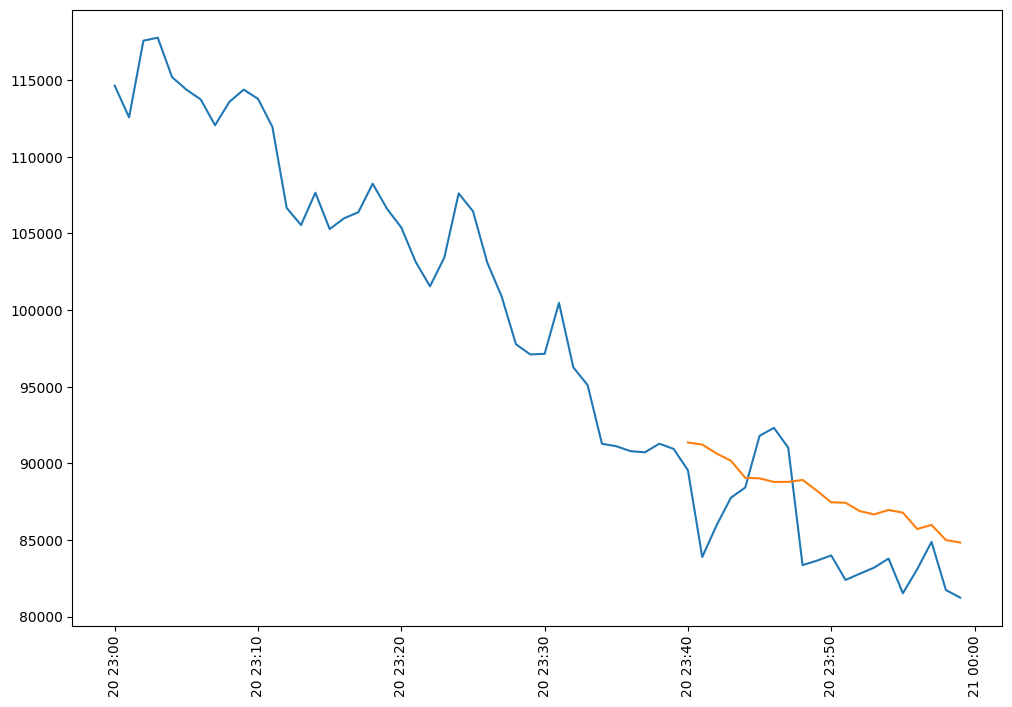

In [133]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(data['b'].iloc[-60:],data['values'].iloc[-60:]);
ax.plot(data['b'].iloc[-20:],predictions[0]);
plt.xticks(rotation=90);

<font color=blue><font size =6>Again Conclusion</font></font><br>
움직임을 어느정도 반영하긴 하지만 변동이 과소평가 되는 경향이 있다 하지만 quantile 예측을 하는경우 괜찮은 결과를 볼 수 있을것 같다
(모델을 한번 돌리는데 시간이 너무 오래걸려 아래에 quantile plot을 해보겠다)

<font color=blue><font size =6>ReAgain</font></font><br>

In [9]:
max_prediction_length = 1440 # forecast 1 Day
max_encoder_length = 2880 # use 2 Day
training_cutoff = max(data['time_idx'])-max_prediction_length
training_cutoff

37439

In [10]:
training = TimeSeriesDataSet(
    data[lambda x : x['time_idx']<=training_cutoff],
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length,
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals=['values'],
    time_varying_known_reals=["time_idx"],

)
training

TimeSeriesDataSet[length=33121](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=2880,
	min_encoder_length=2880,
	min_prediction_idx=0,
	min_prediction_length=1440,
	max_prediction_length=1440,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

In [11]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True,stop_randomization=True
)

In [12]:
batch_size = 16
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [13]:
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val = 0.1, #gradient_clip_val: The value at which to clip gradients
    max_epochs = 50,
    callbacks = [lr_find,early_stopping]
)

NameError: name 'pl' is not defined

In [75]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16,
                        # Q. hidden_vector의 크기가 모델의 성능에 영향을 주나?
                        #hidden_size (int, optional) – hidden recurrent size - the most important hyperparameter along with rnn_layers. Defaults to 10.
                         optimizer = 'adam')

net

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       16
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              NormalDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"monotone_constaints":               {}
  	"n_plotting_samples":                None
  	"n_validation_samples":              None
  	"optimizer":                         adam
  	"optimizer_params":                  None
  	"output_transformer":       

In [ ]:
model = trainer.fit(net,
                    train_dataloaders = train_dataloader,
                    val_dataloaders= val_dataloader
                   )

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [32]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [34]:
predictions,x=best_model.predict(val_dataloader,mode="raw",return_x=True)

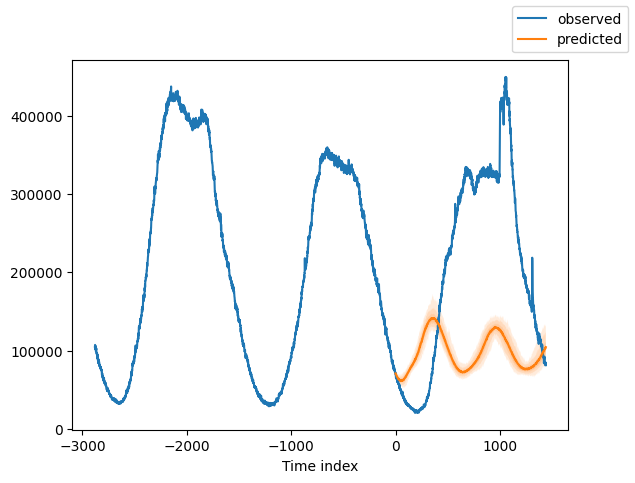

In [42]:
best_model.plot_prediction(x,predictions,idx=0);

In [48]:
import torch
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader,mode='prediction')
print(RMSE()(predictions,actuals))
print(SMAPE()(predictions,actuals))

tensor(165678.8125)
tensor(0.8500)


<font color=blue><font size =6>ReAgain Conclusion</font></font><br>
전체적으로 주기가 적게 평가 된 경향이 있다 TFT에 비교해 낮은 성능을 보인다

~~time_varying_reals_encoder = ['volumn'],<br>
time_varying_reals_decoder = ['volumn'],<br>
추가시 오류 발생<br>
AssertionError: Encoder and decoder variables have to be the same apart from target variable~~

<font color=blue><font size =6>FInal Again</font></font>

In [39]:
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,92408.0,0
1,0,2018-07-25 00:01:00,92150.0,1
2,0,2018-07-25 00:02:00,94896.0,2
3,0,2018-07-25 00:03:00,92694.0,3
4,0,2018-07-25 00:04:00,93674.0,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [40]:
data['new_sub_pred']= np.tile(np.arange(1,1441),27)
data

,group_ids,b,values,time_idx,new_sub_pred
0,0,2018-07-25 00:00:00,92408.0,0,1
1,0,2018-07-25 00:01:00,92150.0,1,2
2,0,2018-07-25 00:02:00,94896.0,2,3
3,0,2018-07-25 00:03:00,92694.0,3,4
4,0,2018-07-25 00:04:00,93674.0,4,5
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875,1436
38876,0,2018-08-20 23:56:00,83092.0,38876,1437
38877,0,2018-08-20 23:57:00,84873.0,38877,1438
38878,0,2018-08-20 23:58:00,81736.0,38878,1439


In [18]:
max_prediction_length = 1440 # forecast 1 Day
max_encoder_length = 2880 # use 2 Day
training_cutoff = max(data['time_idx'])-max_prediction_length
training_cutoff

final_training = TimeSeriesDataSet(
    data,
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length,
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals=['values'],
    time_varying_known_reals=["time_idx","new_sub_pred"]
)


In [23]:
batch_size = 4
final_train_dataloader = final_training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)

In [24]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
net = DeepAR.from_dataset(final_training,
                         rnn_layers = 2,
                         hidden_size = 16,
                         optimizer = 'adam',
                        time_varying_reals_encoder=["values","time_idx","new_sub_pred"],
                        time_varying_reals_decoder=["time_idx","new_sub_pred"]
                         )


/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
model = trainer.fit(net,
                    final_train_dataloader)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [37]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [38]:
datetime=pd.date_range(start='2018-08-21 00:00:00',periods = 1440,freq='T')

In [39]:
# 우리는 known covariate data가 없으므로
new_decoder_data = pd.DataFrame({'group_ids':np.repeat('0',max_prediction_length),
                               'datetime':datetime,
                               'values':np.repeat(data['values'].iloc[-1],max_prediction_length),
                               'time_idx':np.arange(38880,38880+max_prediction_length),
                                'new_sub_pred':np.tile(np.arange(1,1441),1)})
new_encoder_data = data[lambda x: x['time_idx'] > (x['time_idx'].max() - max_encoder_length)]
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_prediction_data

,group_ids,datetime,volumn,time_idx,new_sub_pred
0,0,2018-08-19 00:00:00,94479.0,36000,1
1,0,2018-08-19 00:01:00,94558.0,36001,2
2,0,2018-08-19 00:02:00,93968.0,36002,3
3,0,2018-08-19 00:03:00,92061.0,36003,4
4,0,2018-08-19 00:04:00,90326.0,36004,5
...,...,...,...,...,...
4315,0,2018-08-21 23:55:00,81236.0,40315,1436
4316,0,2018-08-21 23:56:00,81236.0,40316,1437
4317,0,2018-08-21 23:57:00,81236.0,40317,1438
4318,0,2018-08-21 23:58:00,81236.0,40318,1439


In [40]:
new_raw_pred,x=best_model.predict(new_prediction_data , mode='raw',return_x=True)
new_raw_pred

Output(prediction=tensor([[[81314.4453, 82656.1016, 75415.2812,  ..., 77612.2266,
          77733.4375, 81302.4453],
         [80893.0000, 82750.8125, 79552.1875,  ..., 78148.3203,
          76653.3750, 78142.1719],
         [81236.5234, 83731.6406, 79589.4688,  ..., 78876.0312,
          78835.4531, 79997.4453],
         ...,
         [63202.9375, 71743.2812, 52002.7969,  ..., 57101.3125,
          54442.8438, 50959.9531],
         [64282.1562, 71539.6953, 53179.2812,  ..., 56584.2500,
          55646.5469, 50222.2656],
         [63982.6562, 68907.1406, 52568.6250,  ..., 56832.4688,
          52166.5156, 51885.7500]]]))

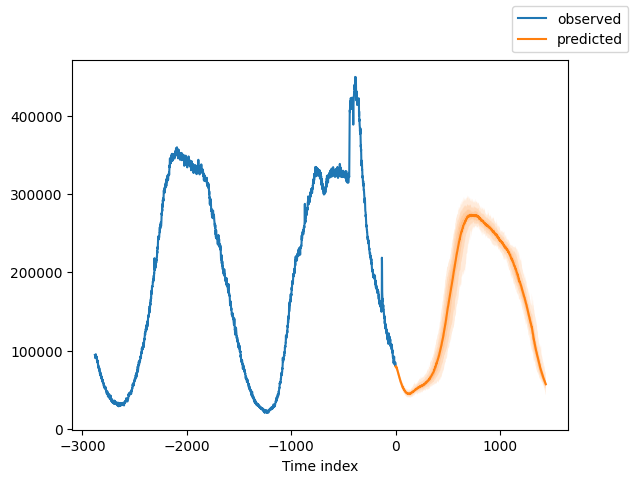

In [41]:
best_model.plot_prediction(x,new_raw_pred,idx=0, show_future_observed = False);
# batchsize=4 epoch를 15번 돌았을때

####################################################

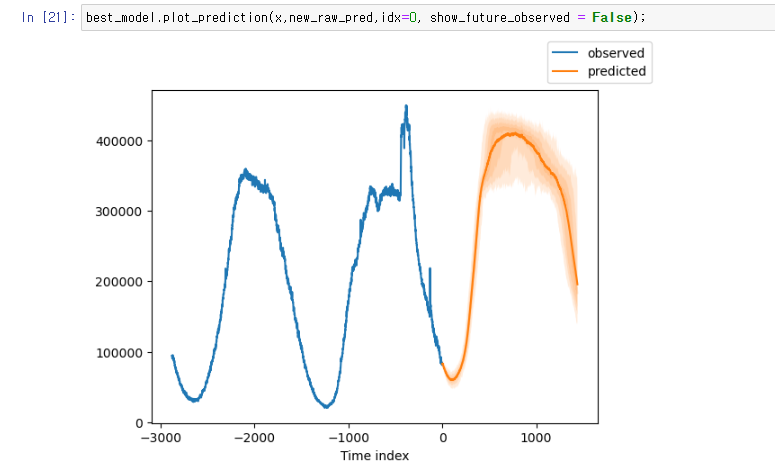
위는 batchsize를 4로 하고 epoch를 1번 돌았을때의 그래프이다
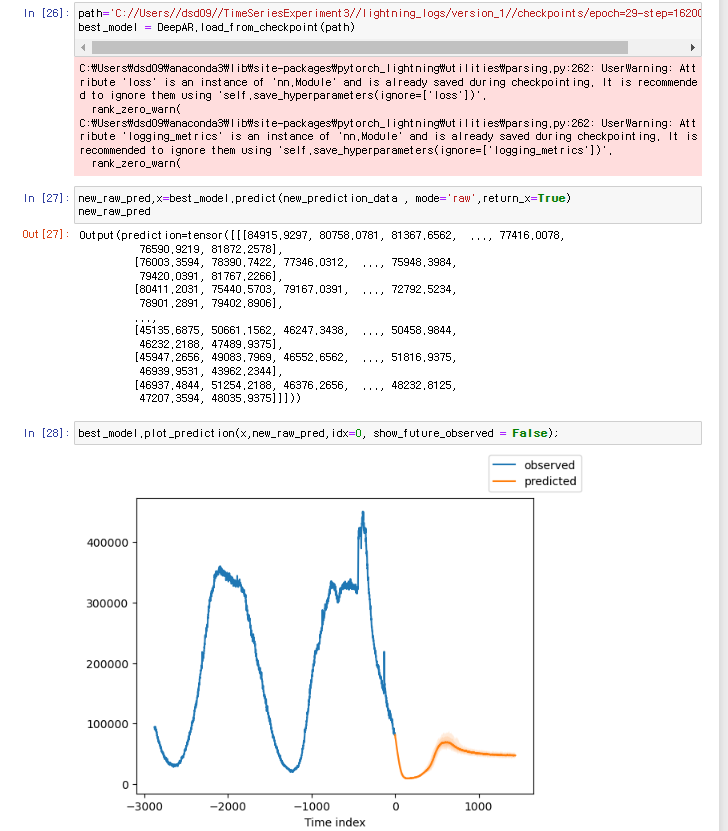
위는 batchsize를 64로 하고 epoch를 29번 돌았을때의 그래프이다 왜 이런 차이가 발생했을까

<font color=blue>
professor opinion: 자연어처리와 같은 예시에서 이런경우가 발생하는데 자연어처리에서 batch size를 키우면 여러데이터중에 대표데이터 하나만 보려고 하는 경향이 생긴다 그거와 같은 논의로 생각해볼 수 있을것 같다</font>